# Optimización de hiperparámetros: función de activación.


@Tesis: Modelo de segmentación semántica de columnas de humo derivadas de incendios forestales en México

@Autor: Colvert Gomez Rubio

### Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.nn import functional
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import pandas as pd
import time
from torch.cuda import amp

### GPU ó CPU

In [2]:
# Verificar si CUDA está disponible y seleccionar el dispositivo correspondiente
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Inicializar el escalador de gradientes
scaler = amp.GradScaler()

cuda


### Directorios

In [3]:
 # Definimos la ruta base para nuestro dataset
base_path = os.path.join(os.path.dirname(os.getcwd()) , 'GOES16-wildfires-smoke-plumes-dataset\GOES16-wildfires-smoke-plumes-dataset')

 # Definimos las rutas para los conjuntos de entrenamiento y sus máscaras
train_path = os.path.join(base_path, 'train')
train_masks_path = os.path.join(base_path, 'train_masks')

 # Definimos las rutas para los conjuntos de validación y sus máscaras
valid_path = os.path.join(base_path, 'valid')
valid_masks_path = os.path.join(base_path, 'valid_masks')

 # Definimos las rutas para los conjuntos de prueba y sus máscaras
test_path = os.path.join(base_path, 'test')
test_masks_path = os.path.join(base_path, 'test_masks')

### Dataset

In [4]:
class SmokeDataset(Dataset):
    """
    Clase para representar un conjunto de datos de imágenes y máscaras de humo.

    Parámetros:
        images (str): Ruta al directorio que contiene las imágenes.
        masks (str, opcional): Ruta al directorio que contiene las máscaras. Default es None.
        img_transforms (callable, opcional): Transformaciones a aplicar a las imágenes. Default es None.
        mask_transforms (callable, opcional): Transformaciones a aplicar a las máscaras. Default es None.

    Atributos:
        images (str): Ruta al directorio que contiene las imágenes.
        masks (str, opcional): Ruta al directorio que contiene las máscaras.
        img_transforms (callable, opcional): Transformaciones a aplicar a las imágenes.
        mask_transforms (callable, opcional): Transformaciones a aplicar a las máscaras.
        image_files (list): Lista ordenada de nombres de archivo de las imágenes en el directorio.
        mask_files (list): Lista ordenada de nombres de archivo de las máscaras en el directorio.

    Excepciones
        AssertionError: Si se proporcionan máscaras, pero el número de imágenes y máscaras no coincide.

    Metodos:
        __len__(): Retorna el número de imágenes en el conjunto de datos.
        __getitem__(idx): Retorna la imagen y su máscara asociada en la posición 'idx'.

    Ejemplo:
        dataset = SmokeDataset(images='/ruta/a/imagenes', masks='/ruta/a/mascaras',
                              img_transforms=transforms.Compose([transforms.Resize((256, 256)),
                                                                transforms.ToTensor()]),
                              mask_transforms=transforms.Compose([transforms.Resize((256, 256)),
                                                                 transforms.ToTensor()]))
        image, mask = dataset[0]

    """

    def __init__(self, images, masks = None, img_transforms = None, mask_transforms = None):
        """
        Constructor de la clase SmokeDataset.

        Parámetros:
            images (str): Ruta al directorio que contiene las imágenes.
            masks (str, opcional): Ruta al directorio que contiene las máscaras. Default es None.
            img_transforms (callable, opcional): Transformaciones a aplicar a las imágenes. Default es None.
            mask_transforms (callable, opcional): Transformaciones a aplicar a las máscaras. Default es None.

        """
        self.images = images
        self.masks = masks

        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        # Inicializar listas de archivos de imágenes y máscaras
        self.image_files = []
        self.mask_files = []

        # Si se proporcionan máscaras, asegurar que el número de imágenes y máscaras coincida
        if self.masks is not None:
            assert len(os.listdir(self.images)) == len(os.listdir(self.masks)), 'no hay el mismo número de imágenes y máscaras'
            # Obtener lista de archivos de imágenes y máscaras ordenados
            self.image_files = sorted(os.listdir(self.images))
            self.mask_files = sorted(os.listdir(self.masks))
        else:
            # Obtener lista de archivos de imágenes ordenados
            self.image_files = sorted(os.listdir(self.images))

    def __len__(self):
        """
        Método para obtener la cantidad de imágenes en el conjunto de datos.

        Retorna:
            int: Número de imágenes en el conjunto de datos.

        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Método para obtener la imagen y su máscara asociada en la posición 'idx'.

        Parámetros:
            idx (int): Índice de la imagen a obtener.

        Retorna:
            tuple: Tupla con la imagen y su máscara asociada, si las máscaras están disponibles.
                   Si no hay máscaras, retorna solo la imagen.

        """

        image_name = os.path.join(self.images, self.image_files[idx])
        img = Image.open(image_name)
        # Transformar la imagen a tensor
        trans = transforms.ToTensor()

        # Aplicar transformaciones a la imagen si se proporcionan
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img = trans(img)

        # Si se proporcionan máscaras, obtener y transformar la máscara asociada a la imagen
        if self.masks is not None:
            mask_name = os.path.join(self.masks, self.mask_files[idx])
            mask = Image.open(mask_name)
            # Aplicar transformaciones a la máscara si se proporcionan
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            # Normalizar la máscara
            mask_max = mask.max().item()
            mask /= mask_max
            return img, mask
        else:
            return img

In [5]:
#Definir la transformación de datos
transform_data = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.ToTensor()])

# Crear el conjunto de datos de entrenamiento
train_dataset = SmokeDataset(train_path, train_masks_path,
                             img_transforms = transform_data,
                             mask_transforms = transform_data)

# Crear el conjunto de datos de validación
val_dataset = SmokeDataset(valid_path, valid_masks_path,
                           img_transforms = transform_data, mask_transforms = transform_data)

# Crear el conjunto de datos de prueba
test_dataset = SmokeDataset(test_path, test_masks_path, 
                            img_transforms = transform_data, mask_transforms = transform_data)

print(f'Número de imágenes de entrenamiento: {len(train_dataset)}, validación: {len(val_dataset)}, prueba:{len(test_dataset)}')

Número de imágenes de entrenamiento: 731, validación: 207, prueba:123


### DataLoader

In [6]:
# Tamaño del lote
batch_size =  16

# DataLoader de entrenamiento, validación y prueba 
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = False)

print(len(train_loader), len(val_loader), len(test_loader))
print(f'Número de mini-batches de train: {len(train_loader)}, val: {len(val_loader)}, test:{len(test_loader)}')

46 13 1
Número de mini-batches de train: 46, val: 13, test:1


### Métricas

In [7]:
def metrics(model, loader):
    """
    Calcula la precisión y otras métricas de evaluación para un modelo dado utilizando un DataLoader.

    Parámetros:
        model (torch.nn.Module): El modelo a evaluar.
        loader (torch.utils.data.DataLoader): DataLoader que contiene los datos de evaluación.

    Retorna:
        tuple: Una tupla que contiene las siguientes métricas de evaluación:
            - val_cost (float): Costo promedio de la función de pérdida (cross_entropy).
            - val_acc (float): Precisión (accuracy) promedio del modelo.
            - dice (float): Coeficiente Dice, una medida de similitud entre las predicciones y las etiquetas reales.
            - iou (float): Índice de Jaccard (IoU), otra medida de similitud para problemas de segmentación.
            - tp (int): True Positives.
            - tn (int): True Negatives.
            - fp (int): False Positives.
            - fn (int): False Negatives.
    """
    cost = 0.0
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    model = model.to(device=device)
    # Desactiva el cálculo del gradiente durante la ejecución de este bloque de código
    with torch.no_grad():
        # Itera sobre los datos del cargador
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            with amp.autocast():
                # Calcula las puntuaciones del modelo
                scores = model(x)
                # Calcula el costo utilizando la función de pérdida de entropía cruzada
                cost += functional.cross_entropy(scores, y).item()
                # Calcula las predicciones del modelo
                preds = torch.max(scores, dim=1)[1]

                # Calcula TP, TN, FP, FN
                tp += ((preds == 1) & (y == 1)).sum().item()
                tn += ((preds == 0) & (y == 0)).sum().item()
                fp += ((preds == 1) & (y == 0)).sum().item()
                fn += ((preds == 0) & (y == 1)).sum().item()

    # Calcular las métricas finales
    dice = (2 * tp) / (2 * tp + fp + fn + 1e-8)
    iou = (tp) / (tp + fp + fn + 1e-8)
    acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    val_cost = cost / len(loader)
    
    return val_cost, acc, dice, iou, tp, tn, fp, fn

### Función de entrenamiento

In [8]:
def train(model, optimiser, scheduler = None, epochs = 5, store_every = 1):
    """
    Entrena el modelo utilizando el optimizador especificado durante varias épocas.

    Parámetros:
        model (torch.nn.Module): El modelo a entrenar.
        optimiser (torch.optim.Optimizer): El optimizador utilizado para actualizar los pesos del modelo.
        scheduler (torch.optim.lr_scheduler._LRScheduler, opcional): El programador de tasas de aprendizaje (LR scheduler).
            Por defecto, es None, lo que significa que no se utiliza un programador de tasas de aprendizaje.
        epochs (int, opcional): El número de épocas (iteraciones completas) para entrenar el modelo. Por defecto es 5.
        store_every (int, opcional): Intervalo de épocas para almacenar las métricas. Por defecto es 1.

    Retorna:
        None: La función no devuelve nada, pero entrena el modelo y almacena las métricas en listas globales.
              (train_acc_history, val_acc_history, train_cost_history, val_cost_history, dice_history, iou_history)

    Notas:
        - Antes de comenzar el entrenamiento, el modelo se mueve al dispositivo especificado (por defecto 'device').
        - La función utiliza las métricas de precisión (accuracy) y pérdida (cross_entropy) para evaluar el rendimiento
          del modelo en el conjunto de entrenamiento y validación en cada época.
        - Las métricas se imprimen al final de cada época.
        - Si se proporciona un programador de tasas de aprendizaje (scheduler), se aplica a cada paso de optimización.
    """
    start_time = time.time()  # Obtener el tiempo de inicio del entrenamiento

    # Crear DataFrame vacío
    history_df = pd.DataFrame()

    model = model.to(device=device)

    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.

        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)

            optimiser.zero_grad()

            with amp.autocast():
                #Calcula las puntuaciones y el coste
                scores = model(x)
                cost = functional.cross_entropy(input=scores, target=y)

            #Realiza un paso de optimización
            # cost.backward()
            scaler.scale(cost).backward()
            # optimiser.step()
            scaler.step(optimiser)
            scaler.update()

            # Si se proporciona un programador, se aplica a cada paso de optimización
            if scheduler:
                scheduler.step()

            #Calcula las métricas de entrenamiento
            with torch.no_grad():
                train_predictions = torch.argmax(scores, dim=1)
                train_correct_num += (train_predictions == y).sum()
                train_total += torch.numel(train_predictions)
                train_cost_acum += cost

        # Calcula e imprime las métricas al final de cada época
        if epoch%store_every == 0:
            model.eval()
            train_cost2, train_acc2, train_dice, train_iou, tp, tn, fp, fn = metrics(model, train_loader)
            val_cost, val_acc, val_dice, val_iou, tp, tn, fp, fn = metrics(model, val_loader)

            train_acc = float(train_correct_num) / train_total
            train_cost_every = float(train_cost_acum) / len(train_loader)

            print(f'epoch: {epoch + 1}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                  f' train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                  f' dice train: {train_dice:.4f}, dice val: {val_dice:.4f},'
                  f' iou train: {train_iou:.4f}, iou val: {val_iou:.4f}')

            # Almacena las métricas en el DataFrame
            history_df.loc[epoch, 'epoch'] = epoch + 1

            history_df.loc[epoch, 'train_acc'] = train_acc
            history_df.loc[epoch, 'val_acc'] = val_acc

            history_df.loc[epoch, 'train_cost'] = train_cost_every
            history_df.loc[epoch, 'val_cost'] = val_cost

            history_df.loc[epoch, 'train_dice'] = train_dice
            history_df.loc[epoch, 'val_dice'] = val_dice

            history_df.loc[epoch, 'train_iou'] = train_iou
            history_df.loc[epoch, 'val_iou'] = val_iou


    end_time = time.time()  # Obtener el tiempo de finalización del entrenamiento
    total_time = end_time - start_time  # Calcular el tiempo total de ejecución

    # Convertir el tiempo total a formato horas:minutos:segundos
    total_time_str = time.strftime("%H:%M:%S", time.gmtime(total_time))

    # Imprimir el tiempo total de ejecución en formato horas:minutos:segundos
    print("Tiempo total de ejecución:", total_time_str)

    return history_df

### Modelo UNet

In [9]:
class Conv3k(nn.Module):
    def __init__(self, channels_in, channels_out):
        """
        Inicializa una capa de convolución 2D con kernel de tamaño 3x3, stride de 1 y padding de 1.

        Parámetros:
            channels_in (int): Número de canales de entrada.
            channels_out (int): Número de canales de salida.
        """
        super().__init__()
        #Capa de convolución
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size = 3, stride = 1, padding = 1)

    def forward(self, x):
        """
        Realiza una operación de convolución 2D con la entrada dada.

        Parámetros:
            x (torch.Tensor): Tensor de entrada.

        Retorna:
            torch.Tensor: Tensor resultante después de la convolución.
        """
        return self.conv1(x)


class DoubleConv(nn.Module):
    def __init__(self, channels_in, channels_out, activation_fn):
        """
        Inicializa un bloque de doble convolución seguido de normalización y función de activación ReLU.

        Parámetros:
            channels_in (int): Número de canales de entrada.
            channels_out (int): Número de canales de salida.
            activation_fn (nn.Module): Función de activación a utilizar.
        """
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv3k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           activation_fn,

                           Conv3k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           activation_fn,
                            )

    def forward(self, x):
        """
        Realiza una operación de doble convolución seguida de normalización y ReLU.

        Parámetros:
            x (torch.Tensor): Tensor de entrada.

        Retorna:
            torch.Tensor: Tensor resultante después de la doble convolución.
        """
        return self.double_conv(x)


class DownConv(nn.Module):
    def __init__(self, channels_in, channels_out, activation_fn):
        """
        Inicializa un bloque de convolución descendente que incluye una capa de MaxPool2D y una DoubleConv.

        Parámetros:
            channels_in (int): Número de canales de entrada.
            channels_out (int): Número de canales de salida.
            activation_fn (nn.Module): Función de activación a utilizar.
        """
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2, 2),
                        DoubleConv(channels_in, channels_out, activation_fn)
                        )

    def forward(self, x):
        """
        Realiza una operación de convolución descendente con la entrada dada.

        Parámetros:
            x (torch.Tensor): Tensor de entrada.

        Retorna:
            torch.Tensor: Tensor resultante después de la convolución descendente.
        """
        return self.encoder(x)


class UpConv(nn.Module):
    def __init__(self, channels_in, channels_out, activation_fn):
        """
        Inicializa un bloque de convolución ascendente que incluye una capa de Upsample, una capa de convolución y una DoubleConv.

        Parámetros:
            channels_in (int): Número de canales de entrada.
            channels_out (int): Número de canales de salida.
            activation_fn (nn.Module): Función de activación a utilizar.
        """
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        nn.Conv2d(channels_in, channels_in // 2, kernel_size = 1, stride = 1)
                        )
        self.decoder = DoubleConv(channels_in, channels_out, activation_fn)

    def forward(self, x1, x2):
        """
        Realiza una operación de convolución ascendente con las entradas dadas.

        Parámetros:
            x1 (torch.Tensor): Tensor de entrada upsampled.
            x2 (torch.Tensor): Tensor de entrada para la concatenación.

        Retorna:
            torch.Tensor: Tensor resultante después de la convolución ascendente.
        """
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.decoder(x)


class Unet(nn.Module):
    def __init__(self, channels_in, channels, num_classes, activation_fn):
        """
        Inicializa una arquitectura U-Net que consiste en bloques de convolución descendente y ascendente.

        Parámetros:
            channels_in (int): Número de canales de entrada.
            channels (int): Número de canales para las capas intermedias.
            num_classes (int): Número de clases de salida.
            activation_fn (nn.Module): Función de activación a utilizar.
        """
        super().__init__()
        self.first_conv = DoubleConv(channels_in, channels, activation_fn)
        self.down_conv1 = DownConv(channels, 2 * channels, activation_fn)
        self.down_conv2 = DownConv(2 * channels, 4 * channels, activation_fn)
        self.down_conv3 = DownConv(4 * channels, 8 * channels, activation_fn)

        self.middle_conv = DownConv(8 * channels, 16 * channels, activation_fn)

        self.up_conv1 = UpConv(16 * channels, 8 * channels, activation_fn)
        self.up_conv2 = UpConv(8 * channels, 4 * channels, activation_fn)
        self.up_conv3 = UpConv(4 * channels, 2 * channels, activation_fn)
        self.up_conv4 = UpConv(2 * channels, channels, activation_fn)

        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size = 1, stride = 1)

    def forward(self, x):
        """
        Realiza una pasada hacia adelante a través de la arquitectura U-Net.

        Parámetros:
            x (torch.Tensor): Tensor de entrada.

        Retorna:
            torch.Tensor: Tensor resultante después de pasar por la U-Net.
        """
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)

        x5 = self.middle_conv(x4)

        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)

        return self.last_conv(u4)

### Definición del modelo y entrenamiento

In [10]:
activations = [nn.Sigmoid(), nn.ReLU(), nn.LeakyReLU(), nn.Tanh(), nn.ELU()]
results = []

for activation in activations:
     # Establecer la semilla aleatoria para reproducibilidad
    torch.manual_seed(42)
     # Crear el modelo con la función de activación actual
    model = Unet(3, 32, 2, activation)
     # Epocas
    epochs = 20
     # Definir el optimizador y el scheduler
    optimiser_unet = torch.optim.SGD(model.parameters(),
                                     lr=0.01, momentum=0.95,
                                     weight_decay=1e-4)

     # Entrenar el modelo y obtener los resultados
    print(f"With {activation}:")
    history_df = train(model, optimiser_unet, scheduler = None, epochs=epochs)

     # Guardar los resultados en un diccionario
    result = {"Activation_function": str(activation), "History": history_df}
    results.append(result)

With Sigmoid():
epoch: 1, train cost: 0.2314, val cost: 0.2240, train acc: 0.9145, val acc: 0.9476, dice train: 0.0000, dice val: 0.0000, iou train: 0.0000, iou val: 0.0000
epoch: 2, train cost: 0.0919, val cost: 0.0841, train acc: 0.9547, val acc: 0.9656, dice train: 0.5150, dice val: 0.5234, iou train: 0.3468, iou val: 0.3545
epoch: 3, train cost: 0.0690, val cost: 0.0679, train acc: 0.9762, val acc: 0.9752, dice train: 0.7165, dice val: 0.7122, iou train: 0.5582, iou val: 0.5531
epoch: 4, train cost: 0.0583, val cost: 0.1114, train acc: 0.9792, val acc: 0.9609, dice train: 0.4330, dice val: 0.4181, iou train: 0.2763, iou val: 0.2643
epoch: 5, train cost: 0.0508, val cost: 0.0761, train acc: 0.9816, val acc: 0.9725, dice train: 0.7730, dice val: 0.7792, iou train: 0.6300, iou val: 0.6383
epoch: 6, train cost: 0.0502, val cost: 0.0627, train acc: 0.9815, val acc: 0.9784, dice train: 0.8009, dice val: 0.8057, iou train: 0.6680, iou val: 0.6747
epoch: 7, train cost: 0.0455, val cost: 0.

### Graficas métricas

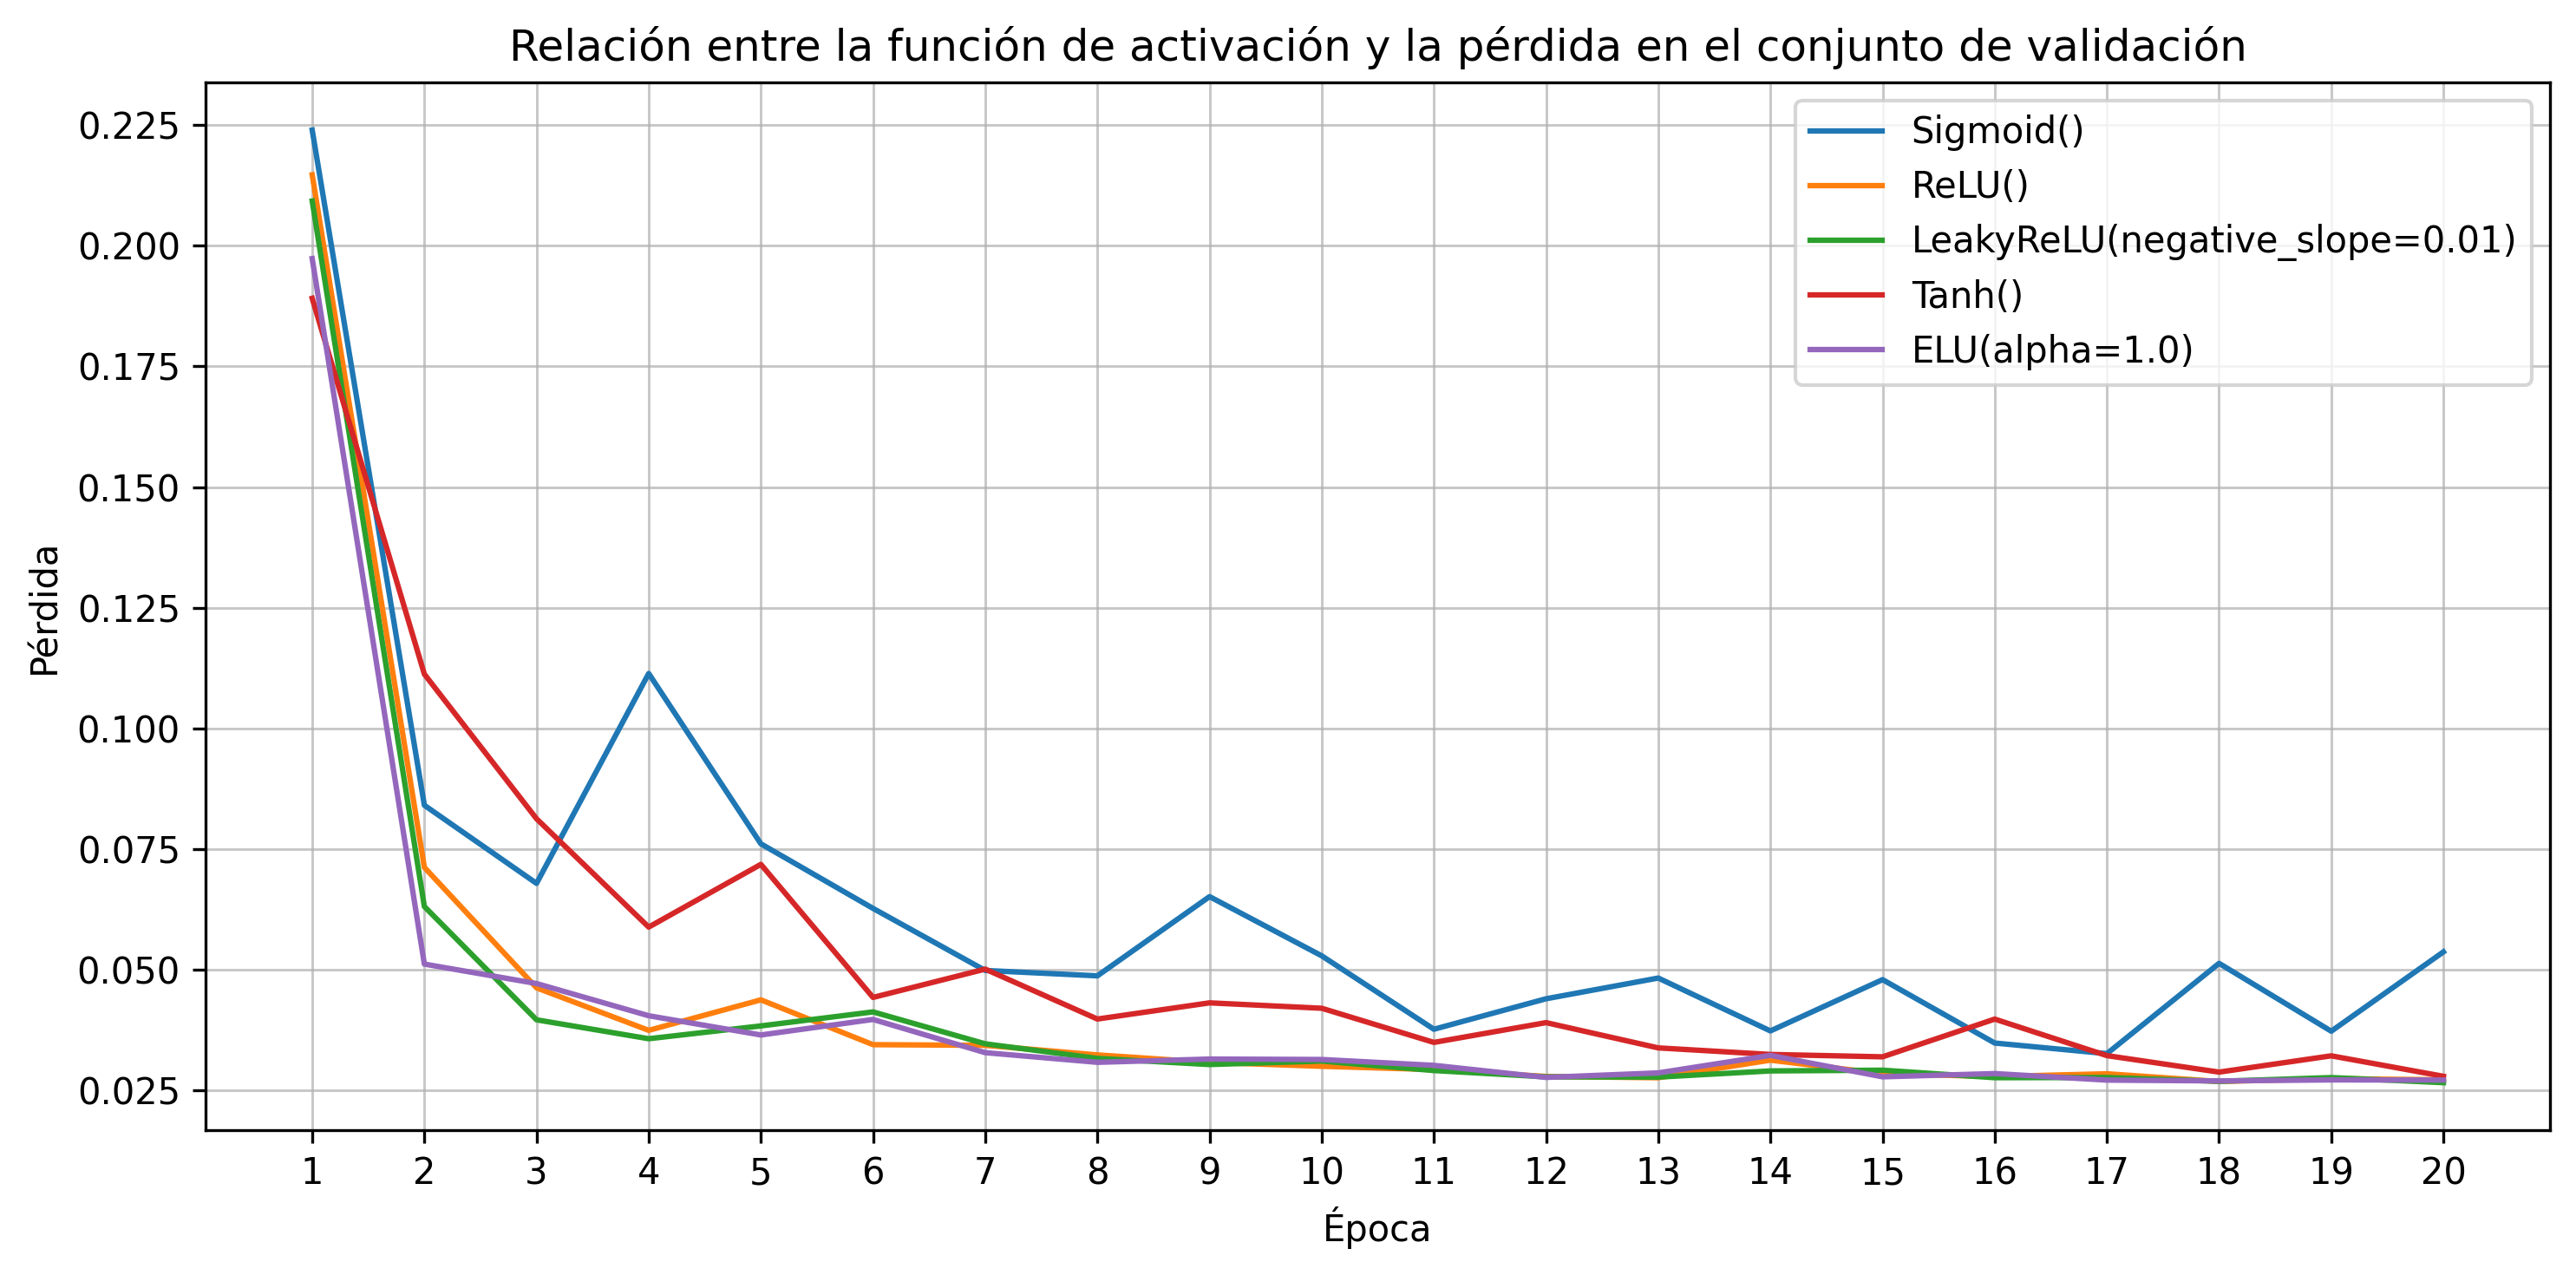

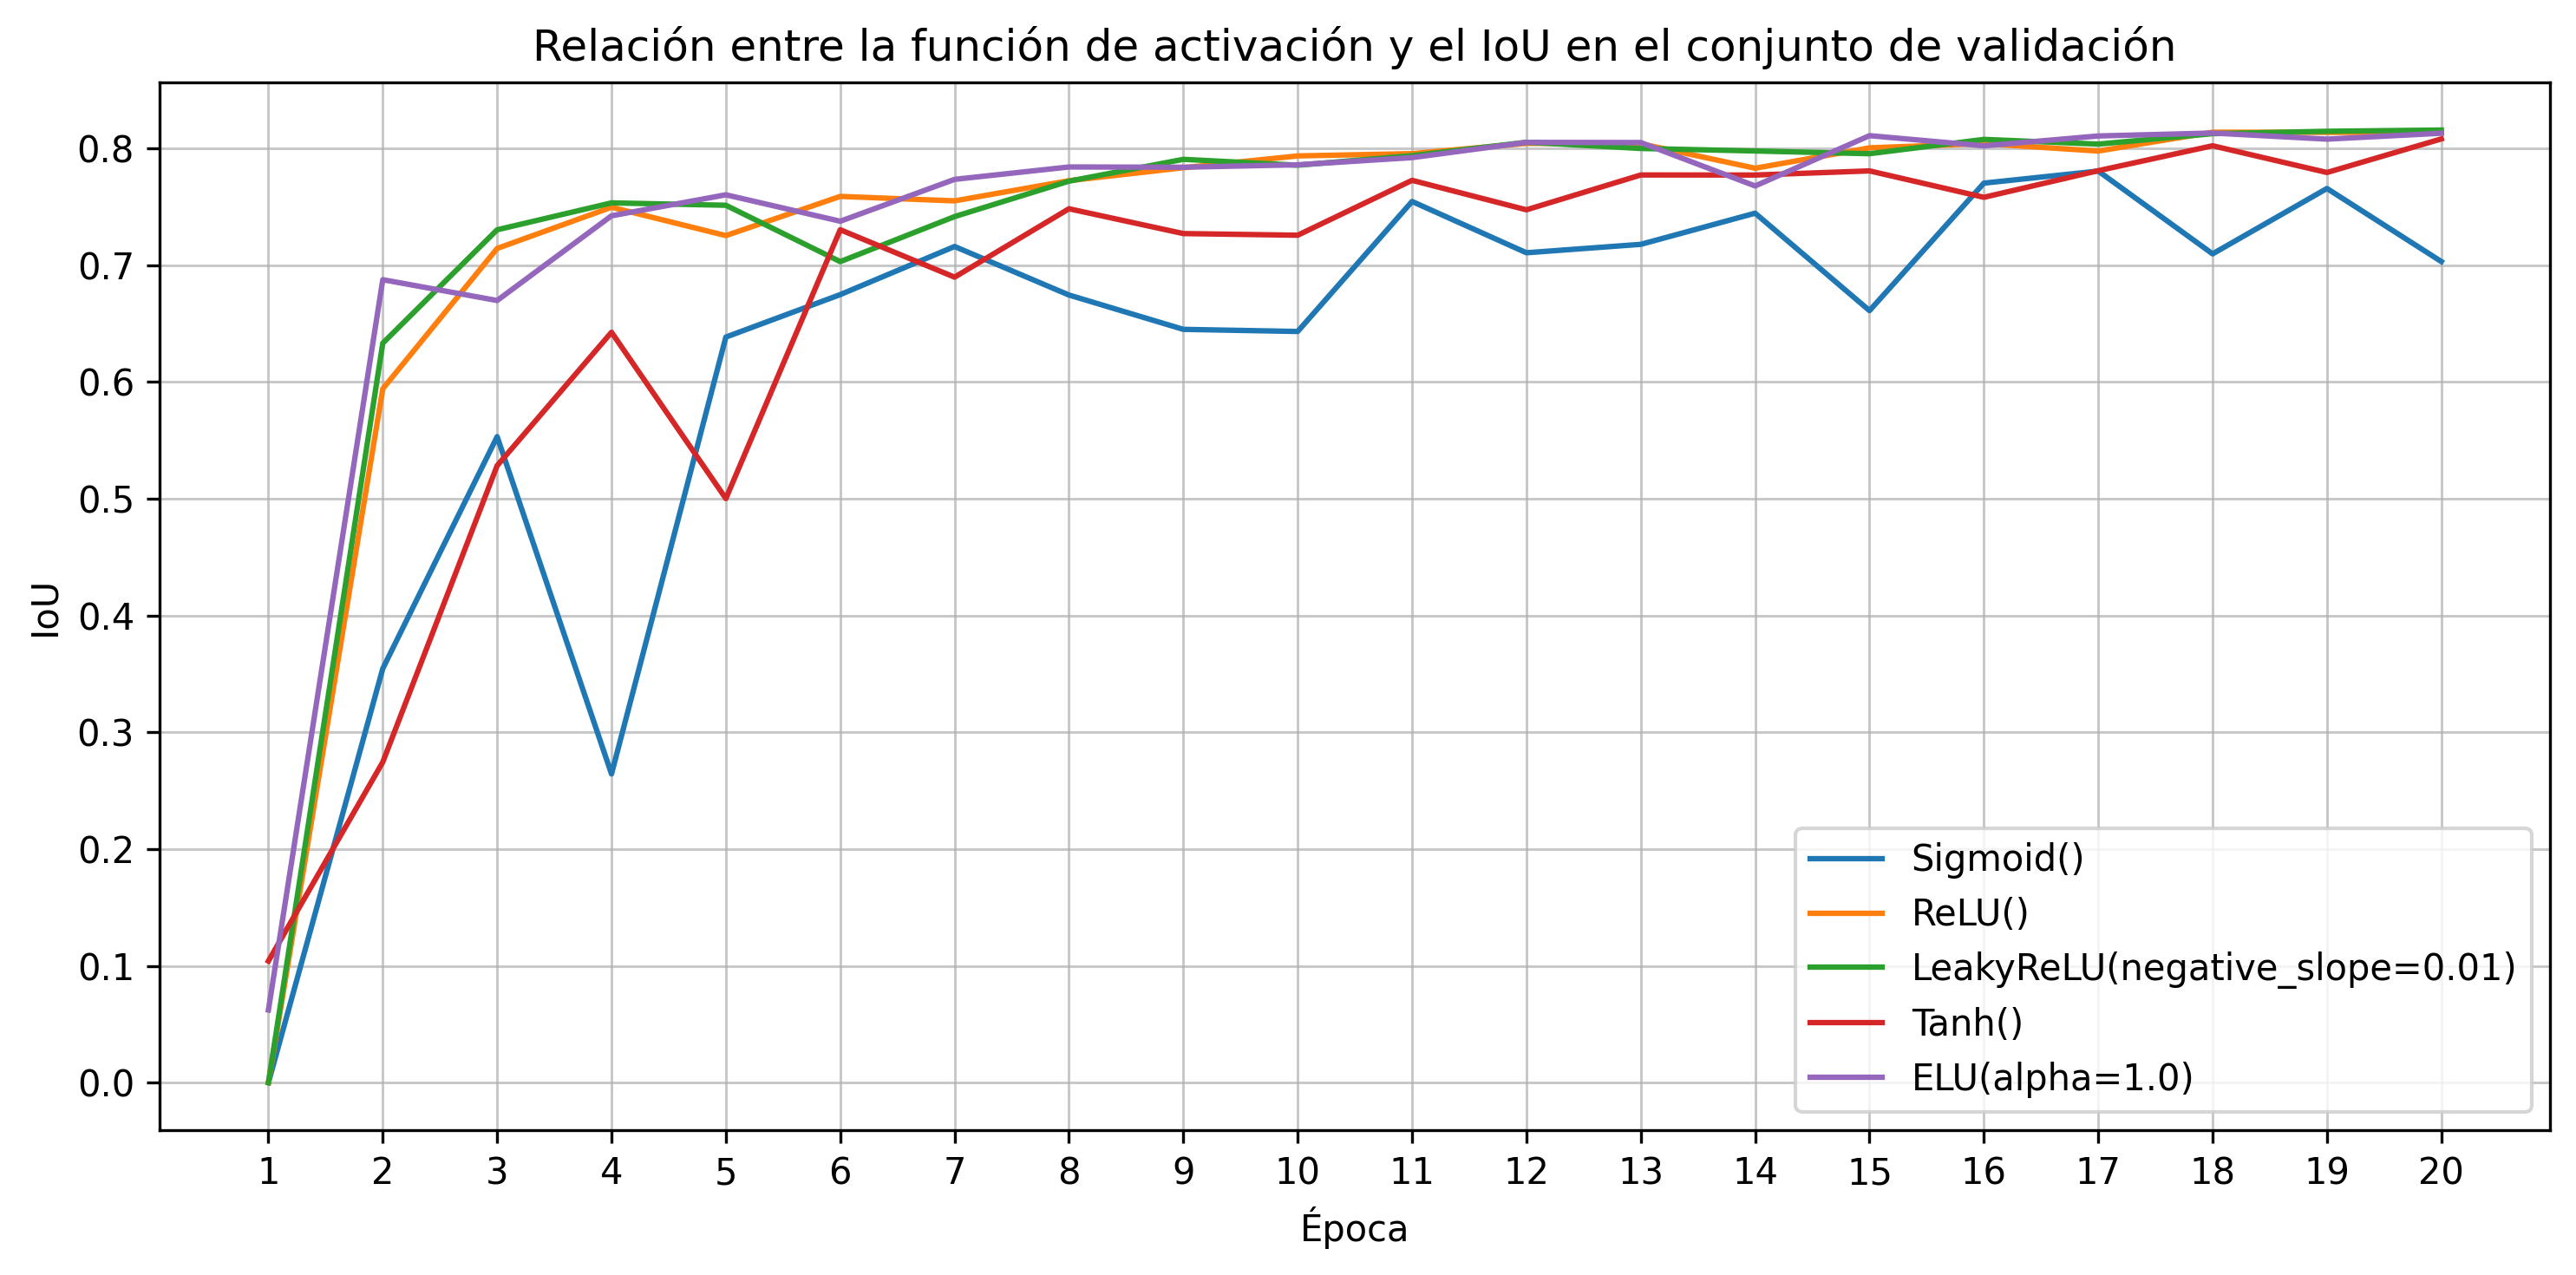

In [21]:
import matplotlib.pyplot as plt

def plot_results(results, y_key, ylabel, title):
    plt.figure(figsize=(10, 5), dpi = 300)
    for n in range(len(results)):
        plt.plot(results[n]["History"]["epoch"], results[n]["History"][y_key], 
                 linestyle='-', label=results[n]["Activation_function"])

    plt.xlabel('Época')
    plt.ylabel(ylabel)
    plt.xticks(results[0]["History"]["epoch"])
    plt.title(title)

    plt.grid(True, linestyle='-', linewidth=0.7, alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Llamadas a la función para cada gráfico
plot_results(results, "val_cost", 'Pérdida', 'Relación entre la función de activación y la pérdida en el conjunto de validación')
plot_results(results, "val_iou", 'IoU', 'Relación entre la función de activación y el IoU en el conjunto de validación')
